# Pre processing for skin lesion dataset

In [1]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [36]:
# Visualização
def show_images(img_list, titles=None):
    """
    Função auxiliar para exibir uma lista de imagens.

    Args:
        img_list (list): Lista de imagens a serem exibidas.
        titles (list, optional): Lista de títulos para cada imagem. Defaults to None.
    """
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(img_list):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img, cmap='viridis')
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Etapa 1.1: Redimensionamento
class Resize(BaseEstimator, TransformerMixin):
    """
    Redimensiona as imagens para um tamanho fixo.
    
    Args:
        size (tuple, optional): O tamanho para o qual as imagens serão redimensionadas.
            Defaults to (128, 128).
    """
    def __init__(self, size=(128, 128)):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [cv2.resize(img, self.size) for img in X]

# Etapa 1.2: Normalização
class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, scaling='minmax'):
        """
        Normaliza as imagens.

        Args:
            scaling (str, optional): O tipo de escalonamento a ser aplicado.
                'minmax': Escala os valores para o intervalo [0, 1].
                'meanstd': Centraliza os dados com média zero e desvio padrão unitário (por canal).
                Defaults to 'minmax'.
        """
        self.scaling = scaling
        self.mean = None
        self.std = None

    def fit(self, X):
        if self.scaling == 'meanstd':
            # Calcula a média e o desvio padrão por canal para o conjunto de treinamento
            X = np.array(X)
            if X.ndim == 4: 
                self.mean = np.mean(X, axis=(0, 1, 2), keepdims=True)
                self.std = np.std(X, axis=(0, 1, 2), keepdims=True)
            elif X.ndim == 3: 
                self.mean = np.mean(X, axis=(0, 1), keepdims=True)
                self.std = np.std(X, axis=(0, 1), keepdims=True)
            else:
                raise ValueError("Formato de entrada não suportado para 'meanstd' scaling.")
        return self

    def transform(self, X):
        X = np.array(X, dtype=np.float32)
        if self.scaling == 'minmax':
            min_val = np.min(X)
            max_val = np.max(X)
            # Evita divisão por zero se min_val == max_val
            return (X - min_val) / (max_val - min_val + 1e-8)
        elif self.scaling == 'meanstd':
            if self.mean is None or self.std is None:
                raise ValueError("O método 'fit' deve ser chamado antes de 'transform' com scaling='meanstd'.")
            return (X - self.mean) / (self.std + 1e-8)
        else:
            raise ValueError(f"Tipo de escalonamento '{self.scaling}' não suportado.")
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
# Etapa 2: Filtro Gaussiano (remoção de ruído)
class GaussianBlur(BaseEstimator, TransformerMixin):
    """
    Aplica um filtro gaussiano para remoção de ruído.
    
    Args:
        ksize (tuple, optional): Tamanho do kernel gaussiano. Defaults to (5, 5).
        sigma (float, optional): Desvio padrão da distribuição gaussiana. Defaults to 0.
    """
    def __init__(self, ksize=(5, 5), sigma=0):
        self.ksize = ksize
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [cv2.GaussianBlur(img, self.ksize, self.sigma) for img in X]

# Etapa 3  (versão 1): CLAHE (Equalização de histograma adaptativa)
class CLAHE(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) em imagens.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in X]

# Etapa 3 (versão 2): CLAHE aplicado em cada canal de cor (BGR)
class CLAHE_Color(BaseEstimator, TransformerMixin):
    """
    Aplica CLAHE em cada canal de cor (BGR) de uma imagem.

    Args:
        clip_limit (float, optional): Limite de recorte para CLAHE. Defaults to 2.0.
        tile_grid_size (tuple, optional): Tamanho da grade para CLAHE. Defaults to (8, 8).
    """
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed_images = []
        for img in X:
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            cl = clahe.apply(l)
            merged_lab = cv2.merge((cl, a, b))
            processed_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
            processed_images.append(processed_img)
        return processed_images

# Etapa 4: Segmentação simples usando Otsu
class OtsuThreshold(BaseEstimator, TransformerMixin):
    """
    Aplica o método de Otsu para segmentação de imagens.

    Args:
        threshold (int, optional): Valor do limiar. Defaults to 0.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binarized = []
        for img in X:
            if len(img.shape) == 3:  # Converte se for imagem colorida
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binarized.append(binary)
        return binarized


## Testando as técnicas que implementamos

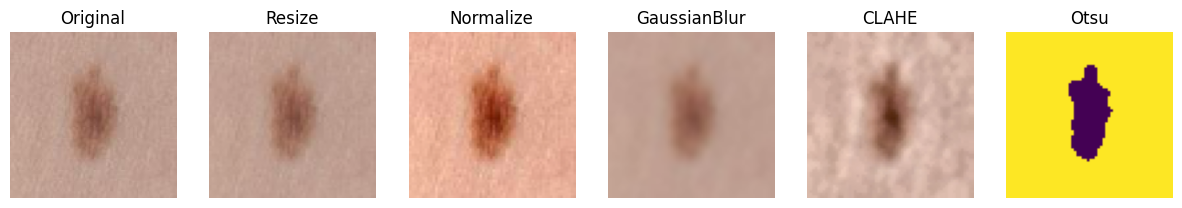

In [37]:
img_path = '../data/03_primary/ISIC_2024/images/ISIC_0087605.jpg'
original = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

step1_0 = Resize((64, 64)).fit_transform([original])
step1_1 = Normalize().fit_transform(step1_0)
step2 = GaussianBlur((5, 5)).fit_transform(step1_0)
step3 = CLAHE_Color().fit_transform(step2)
step4 = OtsuThreshold().fit_transform(step3)

show_images([original, step1_0[0], step1_1[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Resize", "Normalize", "GaussianBlur", "CLAHE", "Otsu"])

# Carregando dataset completo

In [11]:
y_true = pd.read_csv('../data/03_primary/ISIC_2024/label.csv')
#y_true = y_true.iloc[:, 1].values
y_true[y_true.malignant == 1]

,isic_id,malignant
387,ISIC_0082829,1.0
935,ISIC_0096034,1.0
1245,ISIC_0104229,1.0
1846,ISIC_0119495,1.0
3478,ISIC_0157834,1.0
...,...,...
396165,ISIC_9877311,1.0
398671,ISIC_9941636,1.0
399936,ISIC_9972649,1.0
399943,ISIC_9972877,1.0


In [ ]:
# ---------- Dataset ----------
base_path = r'..\data\03_primary\ISIC_2024'
image_folder = os.path.join(base_path, 'images')
csv_path = os.path.join(base_path, 'ISIC_2024_Permissive_Training_GroundTruth.csv')

# Lendo o CSV com os rótulos
df = pd.read_csv(csv_path)

# Separando as classes
df_class_1 = df[df['malignant'] == 1]
df_class_0 = df[df['malignant'] == 0]

# Amostragem da classe 0
df_class_0_sample = df_class_0.sample(n=len(df_class_1), random_state=42)

# Concatenando
df_sample = pd.concat([df_class_1, df_class_0_sample]).reset_index(drop=True)

# Função para carregar uma imagem
def load_image(filename, target_size=(128, 128)):
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path+'.jpg')
    if img is None:
        print(f"Erro ao carregar a imagem: {img_path+'.jpg'}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

# Carregando imagens e labels
images = []
labels = []

for _, row in df_sample.iterrows():
    img = load_image(row['isic_id'])
    if img is not None:
        images.append(img)
        labels.append(row['malignant'])

X = np.array(images)
y = np.array(labels)

# Comprovar se houve melhora ou piora com determinada técnica

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Converte os rótulos em one-hot encoding (se necessário)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # ou 'sigmoid' se for binário
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.5657 - loss: 275.1361 - val_accuracy: 0.4362 - val_loss: 0.7261
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.5029 - loss: 0.7153 - val_accuracy: 0.4362 - val_loss: 0.6936
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.5440 - loss: 0.6800 - val_accuracy: 0.3936 - val_loss: 0.7212
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5459 - loss: 0.7075 - val_accuracy: 0.4255 - val_loss: 0.6938
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5302 - loss: 0.6821 - val_accuracy: 0.4255 - val_loss: 0.6940
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5398 - loss: 0.6902 - val_accuracy: 0.4255 - val_loss: 0.6942
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.5234 - loss: 0.6733 - val_accuracy: 0.4149 - val_loss: 0.6945
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.5603 - loss: 0.6696 - val_accuracy: 

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
              precision    recall  f1-score   support

           0       0.33      0.02      0.03        59
           1       0.50      0.97      0.66        59

   micro avg       0.49      0.49      0.49       118
   macro avg       0.41      0.49      0.34       118
weighted avg       0.41      0.49      0.34       118
 samples avg       0.49      0.49      0.49       118



In [24]:
print(X_processed.shape)  

(588, 64, 64)


In [26]:

# Filtrando apenas duas classes para classificação binária (ex: 0 e 1)
mask = (y.flatten() == 0) | (y.flatten() == 1)
X = X[mask]
y = y[mask]
y = y.flatten()

# ---------- Pipeline de pré-processamento ----------
preprocess_pipeline = Pipeline([
    ('resize', Resize((64, 64))),
    ('blur', GaussianBlur()),
    ('clahe', CLAHE())
])

X_processed = preprocess_pipeline.fit_transform(X)
X_processed = np.array(X_processed) / 255.0  # normalizando
X_processed = np.expand_dims(X_processed, axis=-1)

# ---------- Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# ---------- Modelo simples com TensorFlow ----------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_split=0.1)

# ---------- Avaliação ----------
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5142 - loss: 0.7033 - val_accuracy: 0.4894 - val_loss: 0.6942
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5290 - loss: 0.6918 - val_accuracy: 0.4894 - val_loss: 0.6921
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4890 - loss: 0.6915 - val_accuracy: 0.5532 - val_loss: 0.6899
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6007 - loss: 0.6880 - val_accuracy: 0.5319 - val_loss: 0.6841
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5601 - loss: 0.6824 - val_accuracy: 0.4894 - val_loss: 0.7188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        53
         1.0       0.55      1.00      0.71        65

    accuracy                           0.55       118
   macro avg       0.28      0.50      0.36       118
weighted avg       0.30      0.55      0.39       118



c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\samir\OneDrive\Área de Trabalho\projeto_pdi\skin_cancer_detection\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

# Criando mapa de calor com o saliency_map

In [28]:
import tensorflow as tf

In [49]:
def saliency_map(model, image):
    image = tf.convert_to_tensor(image[None, ...])  # adiciona batch dimension
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        loss = predictions[0][0]  # valor da saída (classe)

    grads = tape.gradient(loss, image)[0]  # gradiente em relação à imagem
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # maior influência entre canais (1 canal no caso)
    
    # Normaliza o mapa
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-10)

    return saliency.numpy()

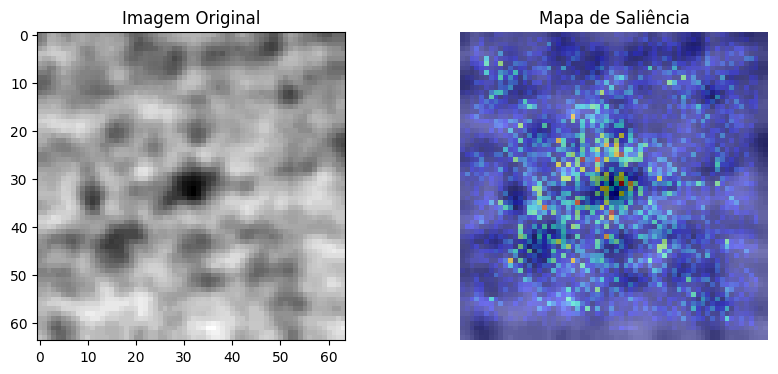

In [50]:
# Escolha uma imagem de teste
img = X_test[0]  # imagem com shape (64, 64, 1)

# Chamada
saliency = saliency_map(model, img)

# Visualização
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Imagem Original")

plt.subplot(1,2,2)
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title("Mapa de Saliência")
plt.axis('off')
plt.show()